In [93]:
%reload_ext autoreload
%autoreload 2

import json
import os

import tqdm
import torch
import pyro
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyro.distributions as dist
from typing import Dict, Optional, NamedTuple

import mira
import mira.metamodel.io
import mira.modeling
import mira.sources.petri

from pyciemss.ODE.askem_primitives import sample, infer_parameters, intervene, optimization
from pyciemss.ODE.base import ODE, PetriNetODESystem, Time, State, Solution, Observation, get_name
from pyciemss.utils import state_flux_constraint

In [96]:
class Scenario3Model(PetriNetODESystem):

    def __init__(self, G, *, noise_scale: float = 1):
        super().__init__(G)
        self.register_buffer("noise_scale", torch.as_tensor(noise_scale))
        for param in self.G.parameters.values():
            prior_loc = torch.log(torch.as_tensor(param.value if param.value is not None else 0.01))
            prior_scale = torch.as_tensor(0.1)
            setattr(self, get_name(param), pyro.nn.PyroSample(dist.LogNormal(prior_loc, prior_scale)))

    @pyro.nn.pyro_method
    def observation_model(self, solution: Solution, data: Optional[Dict[str, State]] = None) -> Solution:
        output = []
        for name, value in zip(self.var_order, solution):
            if data is not None and name in data:
                output.append(pyro.sample(
                    f"obs_{name}",
                    pyro.distributions.Normal(value, self.noise_scale).to_event(1),
                    obs=data[name],
                ))
        return tuple(output)


In [100]:
MODEL_PATH = "../../../program-milestones/6-month-milestone/evaluation/"

MODEL_FILES = {
    "biomd958": ("scenario_3/ta_2/scenario3_biomd958.json", "scenario_3/ta_2/scenario3_biomd958_mira.json"),
    "biomd960": ("scenario_3/ta_2/scenario3_biomd960.json", "scenario_3/ta_2/scenario3_biomd960_mira.json"),
    "sir": ("scenario_1/ta_2/scenario1_sir.json", "scenario_1/ta_2/scenario1_sir_mira.json"),
}

DATA_ALIGNMENTS = {
    "biomd958": {
        "I": "Infectious",
        "H": "Hospitalised",
        "R": "Recovered",
        "D": "Fatalities",
    },
    "biomd960": {
        "I": "Infectious",
        "H": "Hospitalized",
        "R": "Recovered",
        "D": "Deceased",
    },
    "sir": {
        "I": "Infectious",
    },
}

DATA_SCALE = {
    "biomd958": 1e-3,
}

def load_data(filename, model_name):
    df = pd.read_csv(filename)
    alignment = DATA_ALIGNMENTS[model_name]

    dates = pd.to_datetime(df["date"])
    tspan = torch.as_tensor(np.array(
        (dates - dates.iloc[0]).dt.total_seconds() / (24 * 60 * 60)
    ))

    obs = {
        alignment[col]: torch.tensor(df[col].values) / DATA_SCALE[model_name]
        for col in df.columns if col in alignment
    }

    return tspan, obs


def load_mira_model(model_name: str) -> PetriNetODESystem:
    model_file, metamodel_file = MODEL_FILES[model_name]
    with open(os.path.join(MODEL_PATH, model_file), "r") as f:
        model_json = json.load(f)
    mira_model = mira.modeling.Model(
        mira.sources.petri.template_model_from_petri_json(model_json)
    )
    mira_metamodel = mira.metamodel.io.model_from_json_file(os.path.join(MODEL_PATH, metamodel_file))
    return mira_model, mira_metamodel

Initial state:  {'Asymptomatic': tensor(0.), 'Exposed': tensor(0.), 'Fatalities': tensor(0.), 'Hospitalised': tensor(0.), 'Infectious': tensor(1.), 'Recovered': tensor(0.), 'Super_spreaders': tensor(5.), 'Susceptible': tensor(43994.)}


,Unnamed: 0,I,R,D,V,H,I_0-9,I_10-19,I_20-29,I_30-39,...,N_10-19,N_20-29,N_30-39,N_40-49,N_50-59,N_60-69,N_70-79,N_80-89,N_90-99,N_100+
count,629.00000,6.290000e+02,6.290000e+02,629.000000,6.290000e+02,629.000000,629.000000,6.290000e+02,6.290000e+02,6.290000e+02,...,629.0,629.0,629.0,629.0,629.0,629.0,629.0,629.0,629.0,629.0
mean,314.00000,1.824148e+06,5.028726e+07,698484.737679,1.926294e+08,45946.521463,134016.499205,2.044128e+05,2.812316e+05,2.721816e+05,...,41765338.0,45180252.0,45598625.0,40561654.0,42008241.0,39723180.0,25830576.0,10732464.0,2704216.0,98160.0
std,181.72094,1.978525e+06,2.344204e+07,209485.974357,7.940621e+07,33017.880513,144782.838801,2.127507e+05,2.919734e+05,2.720895e+05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.00000,1.793920e+05,1.329420e+07,253207.000000,3.081700e+04,0.000000,16245.000000,3.466000e+04,5.042200e+04,4.513700e+04,...,41765338.0,45180252.0,45598625.0,40561654.0,42008241.0,39723180.0,25830576.0,10732464.0,2704216.0,98160.0
25%,157.00000,7.973120e+05,3.146800e+07,548324.000000,1.665916e+08,26372.000000,57118.000000,9.849300e+04,1.384470e+05,1.338750e+05,...,41765338.0,45180252.0,45598625.0,40561654.0,42008241.0,39723180.0,25830576.0,10732464.0,2704216.0,98160.0
50%,314.00000,1.397172e+06,4.320442e+07,684485.000000,2.199655e+08,37921.000000,97126.000000,1.429680e+05,2.006480e+05,1.978420e+05,...,41765338.0,45180252.0,45598625.0,40561654.0,42008241.0,39723180.0,25830576.0,10732464.0,2704216.0,98160.0
75%,471.00000,1.940458e+06,7.726970e+07,930841.000000,2.557774e+08,61421.000000,147339.000000,2.180180e+05,2.937820e+05,2.896690e+05,...,41765338.0,45180252.0,45598625.0,40561654.0,42008241.0,39723180.0,25830576.0,10732464.0,2704216.0,98160.0
max,628.00000,1.129407e+07,9.058354e+07,995401.000000,2.631494e+08,133263.000000,892161.000000,1.338296e+06,1.784822e+06,1.613565e+06,...,41765338.0,45180252.0,45598625.0,40561654.0,42008241.0,39723180.0,25830576.0,10732464.0,2704216.0,98160.0


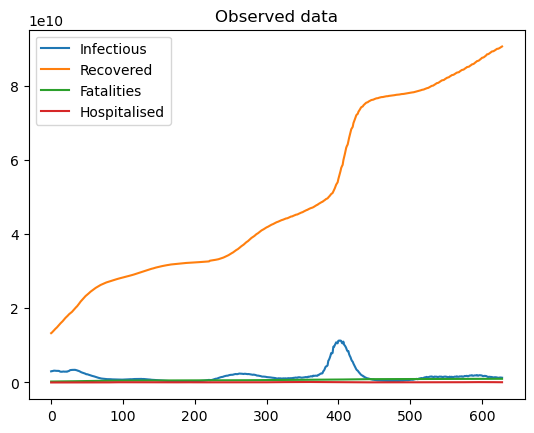

In [101]:
pyro.settings.set(module_local_params=True)
pyro.set_rng_seed(0)
pyro.clear_param_store()

DATA_FILE = "usa-IRDVHN_age.csv"
MODEL_NAME = "biomd958"
NUM_ITERATIONS = 101
OPTIM_PARAMS = {"lr": 1e-2}

mira_model, mira_metamodel = load_mira_model(MODEL_NAME)
model = Scenario3Model(mira_model)

initial_state = model.default_initial_state
tspan, data = load_data(DATA_FILE, MODEL_NAME)

for name, col in data.items():
    plt.plot(tspan, col, label=name)
plt.legend()
plt.title("Observed data")

print("Initial state: ", dict(zip(model.var_order, model.default_initial_state)))
pd.read_csv(DATA_FILE).describe()

In [102]:
# posterior = infer_parameters(model, NUM_ITERATIONS, [], data, initial_state, tspan)
guide = pyro.infer.autoguide.AutoDelta(model)
elbo = pyro.infer.Trace_ELBO()(model, guide)

# initialize
with torch.no_grad():
    elbo(initial_state, tspan, data)

optimizer = torch.optim.Adam(elbo.parameters(), **OPTIM_PARAMS)

for i in tqdm.tqdm(range(NUM_ITERATIONS)):
    optimizer.zero_grad()
    loss = elbo(initial_state, tspan, data)
    loss.backward()
    optimizer.step()
    if i % 10 == 0:
        print(f"iteration {i}: loss = {loss.item()}")

ValueError: Expected parameter loc (Tensor of shape (629,)) of distribution Normal(loc: torch.Size([629]), scale: torch.Size([629])) to satisfy the constraint Real(), but found invalid values:
tensor([ 0.0000e+00,  4.9477e+00, -3.9061e-01,  6.1650e+00, -1.4768e+00,
         7.5821e+00, -3.0900e+00,  9.5105e+00, -5.3540e+00,  1.2188e+01,
        -8.5096e+00,  1.5914e+01, -1.2904e+01,  2.1101e+01, -1.9023e+01,
         2.8323e+01, -2.7543e+01,  3.8378e+01, -3.9406e+01,  5.2377e+01,
        -5.5924e+01,  7.1869e+01, -7.8922e+01,  9.9007e+01, -1.1094e+02,
         1.3679e+02, -1.5553e+02,  1.8940e+02, -2.1760e+02,  2.6265e+02,
        -3.0403e+02,  3.6464e+02, -4.2437e+02,  5.0664e+02, -5.9193e+02,
         7.0434e+02, -8.2521e+02,  9.7962e+02, -1.1500e+03,  1.3629e+03,
        -1.6023e+03,  1.8965e+03, -2.2320e+03,  2.6395e+03, -3.1087e+03,
         3.6740e+03, -4.3294e+03,  5.1144e+03, -6.0289e+03,  7.1199e+03,
        -8.3953e+03,  9.9121e+03, -1.1690e+04,  1.3800e+04, -1.6278e+04,
         1.9213e+04, -2.2665e+04,  2.6750e+04, -3.1558e+04,  3.7243e+04,
        -4.3940e+04,  5.1854e+04, -6.1180e+04,  7.2196e+04, -8.5183e+04,
         1.0052e+05, -1.1860e+05,  1.3996e+05, -1.6514e+05,  1.9486e+05,
        -2.2992e+05,  2.7131e+05, -3.2013e+05,  3.7776e+05, -4.4573e+05,
         5.2596e+05, -6.2059e+05,  7.3232e+05, -8.6407e+05,  1.0196e+06,
        -1.2030e+06,  1.4197e+06, -1.6750e+06,  1.9767e+06, -2.3321e+06,
         2.7522e+06, -3.2470e+06,  3.8321e+06, -4.5207e+06,  5.3355e+06,
        -6.2940e+06,  7.4288e+06, -8.7628e+06,  1.0343e+07, -1.2200e+07,
         1.4400e+07, -1.6987e+07,  2.0049e+07, -2.3651e+07,  2.7913e+07,
        -3.2930e+07,  3.8867e+07, -4.5812e+07,  5.3880e+07, -6.5978e+07,
         9.4742e+07,  1.7855e+08, -5.4626e+09,  7.5041e+11,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan])
                                                                                                                                                                              Trace Shapes:  
                                                                                                                                                                               Param Sites:  
                                                                                                                                                                              Sample Sites:  
rate_(('Susceptible', ('identity', 'ido:0000514')), ('Exposed', ('identity', 'apollosv:00000154')), ('Infectious', ('identity', 'apollosv:00000163')), 'ControlledConversion', 'rate') dist |
                                                                                                                                                                                      value |
    rate_(('Susceptible', ('identity', 'ido:0000514')), ('Exposed', ('identity', 'apollosv:00000154')), ('Hospitalised', ('identity', 'ncit:C25179')), 'ControlledConversion', 'rate') dist |
                                                                                                                                                                                      value |
 rate_(('Susceptible', ('identity', 'ido:0000514')), ('Exposed', ('identity', 'apollosv:00000154')), ('Super_spreaders', ('identity', 'ido:0000463')), 'ControlledConversion', 'rate') dist |
                                                                                                                                                                                      value |
                   rate_(('Exposed', ('identity', 'apollosv:00000154')), ('Asymptomatic', ('identity', 'ido:0000511'), ('disease_status', 'ncit:C3833')), 'NaturalConversion', 'rate') dist |
                                                                                                                                                                                      value |
                                                  rate_(('Exposed', ('identity', 'apollosv:00000154')), ('Super_spreaders', ('identity', 'ido:0000463')), 'NaturalConversion', 'rate') dist |
                                                                                                                                                                                      value |
                                                 rate_(('Exposed', ('identity', 'apollosv:00000154')), ('Infectious', ('identity', 'apollosv:00000163')), 'NaturalConversion', 'rate') dist |
                                                                                                                                                                                      value |
                                                                                                                                                                             p_delta_p dist |
                                                                                                                                                                                      value |
                                                                                                                                                                             a_gamma_a dist |
                                                                                                                                                                                      value |
                                                                                                                                                                             i_gamma_i dist |
                                                                                                                                                                                      value |
                                                                                                                                                                             i_delta_i dist |
                                                                                                                                                                                      value |
                                                                                                                                                                             r_gamma_r dist |
                                                                                                                                                                                      value |
                                                                                                                                                                             h_delta_h dist |
                                                                                                                                                                                      value |
Trace Shapes:
 Param Sites:
Sample Sites: